In [1]:
cd ..

/home/dmitrii/JET_project/training_pipeline


In [73]:
import pandas as pd
import numpy as np
from biosppy.signals.ecg import christov_segmenter

import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score,mean_absolute_error

from utils.data_generators.data_generator import Preprocessing
from utils.peak_finder import Peak_finder
from utils.confusion_matrix_pretty_print import plot_confusion_matrix_from_data
from utils.post_processing import PostProcessing

peak_finder = Peak_finder()
prep = Preprocessing(aug_on=False)
#from models.wavenet import Model

In [3]:
DEBUG_PATH = './data/CV_debug/'
DATA_PATH = './data/JET_data/processed_data/'

patients = [i for i in os.listdir(DEBUG_PATH) if i.find('.')==-1]

print(f'Total number of patients: {len(patients)}')

records = []

for patient in patients:
    
    record = [patient+'/'+i[:-4] for i in os.listdir(DATA_PATH+patient) if i.find('.npy')!=-1]
    
    records+=record
    
print(f'Total number of records {len(records)}')

postprocessing = PostProcessing()

#model = Model.restore(model_name='./data/model_weights/wavenet/wavenet_0_fold_0.71_0.76_1615409816.200047',gpu=None,inference=True)

Total number of patients: 7
Total number of records 8462


# CV KPI

## Download the data

In [4]:
preds = []
error = []
labels = []
signals = []
patients = []

for record in records:
    ann = json.load(open(DEBUG_PATH+record+'.json'))
    error.append(ann['error'])
    preds.append(ann['prediction'])
    labels.append(json.load(open(DATA_PATH+record+'.json'))['label'][1])
    signals.append(np.load(DATA_PATH+record+'.npy'))
    patients.append(record.split('/')[0])     
                 
error = np.array(error)
preds = np.array(preds)
labels = np.array(labels)
signals = np.array(signals)
records = np.array(records)
patients = np.array(patients)

## F1 total

In [7]:
preds_hard = postprocessing.run(preds)

print(f"F1 total: {f1_score(labels,preds_hard,labels=[0,1],average='macro')}")

F1 total: 0.9562125624185731


## F1 for each class

In [8]:
n_classes = 2

labels_oh = np.eye(n_classes)[labels]
preds_oh = np.eye(n_classes)[preds_hard]

for cl in range(n_classes):
    y_temp = labels_oh[:,cl]
    pred_temp = preds_oh[:,cl]
    
    print(f"Class: {cl}, F1 score: {f1_score(y_temp,pred_temp)}")
    print(f"Class: {cl}, balance: {np.mean(y_temp)}")

Class: 0, F1 score: 0.984398590840463
Class: 0, balance: 0.8316000945402978
Class: 1, F1 score: 0.9280265339966832
Class: 1, balance: 0.1683999054597022


# Sensitivity and specificity

In [9]:
print(f"Sensitivity: {precision_score(labels,preds_hard,labels=[0,1],average='macro')}")
print(f"Specificity: {recall_score(labels,preds_hard,labels=[0,1],average='macro')}")
print(f"ROC-AUC score: {roc_auc_score(labels_oh[:,1],preds[:,1])}")

Sensitivity: 0.9380453723431517
Specificity: 0.9773060689239085
ROC-AUC score: 0.9887965615331493


## Confustion Matrix

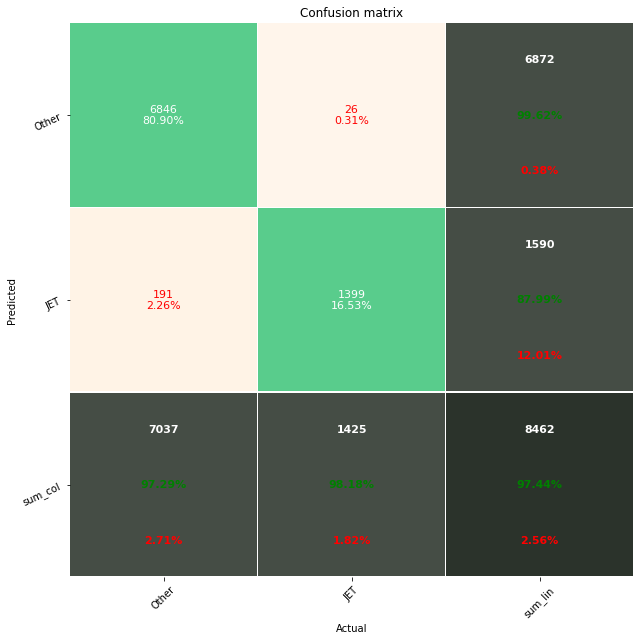

In [10]:
plot_confusion_matrix_from_data(labels,preds_hard,columns=['Other','JET'])

# Calibration reports

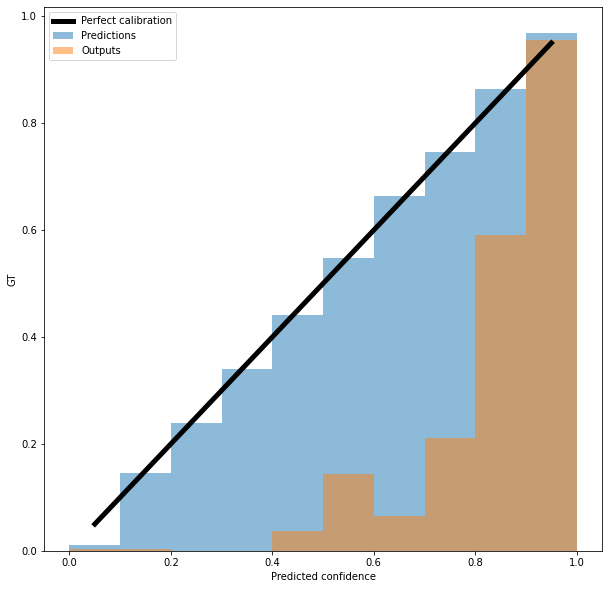

In [93]:
BINS = 10


ranges = [ [i/BINS,(i+1)/BINS] for i in range(BINS)]
ranges_mean = [ np.mean(i) for i in ranges]


dist_pred = []
dist_real = []


perfect_calibration_line = np.arange(0,1,1/BINS)+0.5/BINS


for r in ranges:
    
    label_sub = labels_oh[:,1]
    pred_sub = preds[:,1]
    
    label_sub = label_sub[(pred_sub >= r[0]) & (pred_sub <= r[1])]
    
    pred_sub = pred_sub[(pred_sub >= r[0]) & (pred_sub <= r[1])]

    dist_pred.append(np.mean(pred_sub))
    dist_real.append(np.mean(label_sub))
    
    


plt.figure(figsize=(10,10))
plt.plot(perfect_calibration_line,perfect_calibration_line,'k',linewidth='5')
#plt.plot(dist_pred,dist_real,'r',linewidth='10')
plt.bar(ranges_mean,dist_pred,width=1/BINS, alpha=0.5)
plt.bar(ranges_mean,dist_real,width=1/BINS,alpha=0.5)
plt.xlabel('Predicted confidence')
plt.ylabel('GT')
plt.legend(['Perfect calibration','Predictions','Outputs'])

In [91]:
print(f'Expected calibration error: {mean_absolute_error(dist_real,perfect_calibration_line)} ')

Expected calibration error: 0.3001504951943102 


# Qualitative examples

In [ ]:
labels = np.eye(n_classes, dtype=np.float32)[labels.astype(np.int8)]


inds = error.argsort()
labels = labels[inds[::-1],:]
signals = signals[inds[::-1],:]
records = records[inds[::-1]]
preds = preds[inds[::-1]]

N = 10

#select top best
labels_best = labels[-N:,:].copy()
signals_best = signals[-N:,:]
records_best = records[-N:]
preds_best = preds[-N:]

#select top worst
labels_worst = labels[:N,:].copy()
signals_worst = signals[:N,:].copy()
records_worst = records[:N]
preds_worst = preds[:N]

## Plots

## Worst

In [ ]:
for i in range(N):
    
    #apply preprocessing
    signal = prep.run(signals_worst[i],np.array([1]))
    signal = signal.reshape(-1)
    
    #find heart rate
    rr = peak_finder.find_peaks_abp(signal, threshold=4)  #christov_segmenter(signal=signals_worst[i], sampling_rate=125)
    if rr is not None:
        if rr.shape[0]>5:
            HR = np.median(np.diff(rr))
            HR = 60/(HR/500)
        else:
            HR = -1
            
        fig = plt.figure(figsize=(30,10))
        plt.plot(signal)
        plt.plot(rr,signal[rr],'*')
        plt.title(f'; Label: {labels_worst[i,:]}, Predicted: {np.round(preds_worst[i,:],2)} HR: {HR}')
        print(records_worst[i])
        plt.show()
    else:
        HR = -1
        
        fig = plt.figure(figsize=(30,10))
        plt.plot(signal)
        #plt.plot(rr,signal[rr],'*')
        plt.title(f'; Label: {labels_worst[i,:]}, Predicted: {np.round(preds_worst[i,:],2)} HR: {HR}')
        print(records_worst[i])
        plt.show()
    
    

## Best

In [ ]:
for i in range(N):
    
    #apply preprocessing
    signal = prep.run(signals_best[i],np.array([1]))
    signal = signal.reshape(-1)
    
    #find heart rate
    rr = peak_finder.find_peaks_abp(signal, threshold=4)  #christov_segmenter(signal=signals_worst[i], sampling_rate=125)
    if rr is not None:
        if rr.shape[0]>5:
            HR = np.median(np.diff(rr))
            HR = 60/(HR/500)
        else:
            HR = -1
            
        fig = plt.figure(figsize=(30,10))
        plt.plot(signal)
        plt.plot(rr,signal[rr],'*')
        plt.title(f'; Label: {labels_best[i,:]}, Predicted: {np.round(preds_best[i,:],2)} HR: {HR}')
        print(records_best[i])
        plt.show()
    else:
        HR = -1
        
        fig = plt.figure(figsize=(30,10))
        plt.plot(signal)
        #plt.plot(rr,signal[rr],'*')
        plt.title(f'; Label: {labels_best[i,:]}, Predicted: {np.round(preds_best[i,:],2)} HR: {HR}')
        print(records_best[i])
        plt.show()
    

# Single waveform

In [ ]:
signal = np.load(DATA_PATH+'2726762/636'+'.npy')

#maps = model.get_heatmap(signal)
#maps = np.sum(maps,axis=2)[0,:]

fig = plt.figure(figsize=(30,10))
plt.plot(signal-np.mean(signal),'k',linewidth=2)
#plt.plot(maps*10-700,'g',linewidth=2)
plt.legend(['ECG waveform','Model Activatation Map'])
plt.xlabel('Samples, 500Hz sample rate')
plt.ylabel('Amplitude')

plt.savefig('figure2.eps', format='eps')
plt.show()
